# Laboratorio 3 - CC3045 Inteligencia Artificial

In [24]:
# Si en tal caso no funciona, este comando instala las dependencias c:
# !pip install numpy pandas scikit-learn matplotlib

---
# TASK 2 - FILTRO DE SPAM BAYESIANO
---

In [2]:
# Importar librerías
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

np.random.seed(42)

### 1. Pre-procesamiento

In [3]:
def load_data(filepath):
    """Carga el dataset desde un archivo de texto."""
    labels = []
    messages = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t', 1)
            if len(parts) == 2:
                labels.append(parts[0])
                messages.append(parts[1])
    
    return labels, messages

def clean_text(text):
    """Limpia el texto: minúsculas y elimina puntuación."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def tokenize(text):
    """Tokeniza el texto en palabras."""
    return text.split()

# Cargar y limpiar datos
labels, messages = load_data('entrenamiento.txt') 

cleaned_messages = [clean_text(msg) for msg in messages]

print(f"Total de mensajes: {len(messages)}")
print(f"Spam: {labels.count('spam')}, Ham: {labels.count('ham')}")

Total de mensajes: 5565
Spam: 747, Ham: 4818


In [4]:
# División Train/Test (80/20)
def train_test_split(messages, labels, test_size=0.2, random_state=42):
    indices = np.arange(len(messages))
    np.random.seed(random_state)
    np.random.shuffle(indices)
    
    split_point = int(len(messages) * (1 - test_size))
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]
    
    X_train = [messages[i] for i in train_indices]
    X_test = [messages[i] for i in test_indices]
    y_train = [labels[i] for i in train_indices]
    y_test = [labels[i] for i in test_indices]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(cleaned_messages, labels)
print(f"Entrenamiento: {len(X_train)}, Prueba: {len(X_test)}")

Entrenamiento: 4452, Prueba: 1113


In [5]:
# Generar vocabulario (V)
def build_vocabulary(messages):
    vocab = set()
    for message in messages:
        words = tokenize(message)
        vocab.update(words)
    return vocab

vocabulary = build_vocabulary(X_train)
print(f"Vocabulario: {len(vocabulary)} palabras únicas")

Vocabulario: 7599 palabras únicas


### 2. Entrenamiento (Cálculo de Probabilidades)

In [6]:
# Probabilidades a priori: P(Spam) y P(Ham)
def calculate_priors(labels):
    total = len(labels)
    spam_count = labels.count('spam')
    ham_count = labels.count('ham')
    
    return {
        'spam': spam_count / total,
        'ham': ham_count / total
    }

priors = calculate_priors(y_train)
print(f"P(Spam) = {priors['spam']:.4f}")
print(f"P(Ham) = {priors['ham']:.4f}")

P(Spam) = 0.1336
P(Ham) = 0.8664


In [7]:
# Likelihoods con Laplace Smoothing (k=1)
# Fórmula: P(w_i | Clase) = (Count(w_i en Clase) + k) / (Total palabras en Clase + k*|V|)
def calculate_likelihoods(messages, labels, vocabulary, k=1):
    word_counts = {'spam': Counter(), 'ham': Counter()}
    total_words = {'spam': 0, 'ham': 0}
    
    for message, label in zip(messages, labels):
        words = tokenize(message)
        word_counts[label].update(words)
        total_words[label] += len(words)
    
    vocab_size = len(vocabulary)
    likelihoods = {'spam': {}, 'ham': {}}
    
    for word in vocabulary:
        for label in ['spam', 'ham']:
            count = word_counts[label][word]
            likelihood = (count + k) / (total_words[label] + k * vocab_size)
            likelihoods[label][word] = likelihood
    
    return likelihoods

likelihoods = calculate_likelihoods(X_train, y_train, vocabulary)
print("Likelihoods calculados")

Likelihoods calculados


### 3. Inferencia (Predicción)

In [8]:
# Predicción usando regla de Bayes con logaritmos para evitar underflow
# log P(Clase | Mensaje) ∝ log P(Clase) + Σ log P(w_i | Clase)
def predict(message, priors, likelihoods, vocabulary):
    words = tokenize(message)
    scores = {'spam': np.log(priors['spam']), 'ham': np.log(priors['ham'])}
    
    for word in words:
        if word in vocabulary:
            scores['spam'] += np.log(likelihoods['spam'][word])
            scores['ham'] += np.log(likelihoods['ham'][word])
    
    return 'spam' if scores['spam'] > scores['ham'] else 'ham'

# Hacer predicciones
y_pred = [predict(message, priors, likelihoods, vocabulary) for message in X_test]
print(f"Predicciones completadas: {len(y_pred)}")

Predicciones completadas: 1113


### 4. Evaluación

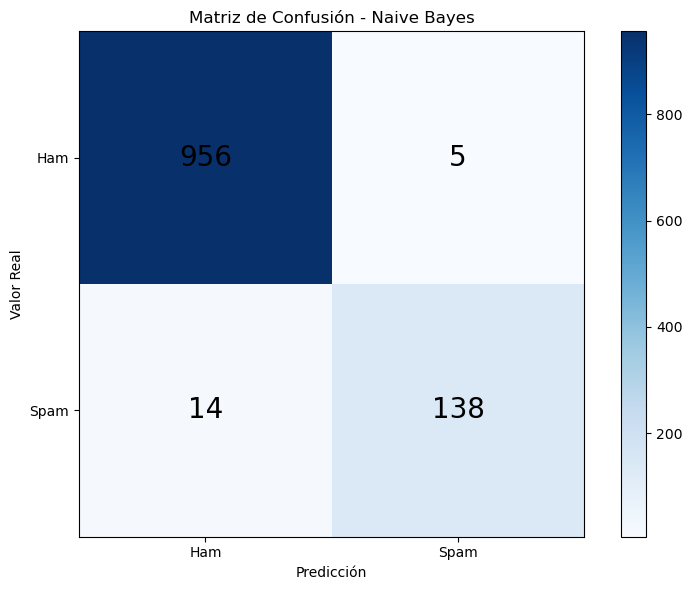


RESULTADOS NAIVE BAYES
Accuracy:  0.9829 (98.29%)
Precision: 0.9650
Recall:    0.9079
F1-Score:  0.9356

Falsos Positivos: 5
Falsos Negativos: 14


In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Añadir números
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=20)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham', 'Spam'])
ax.set_yticklabels(['Ham', 'Spam'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Naive Bayes')
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Métricas
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "="*60)
print("RESULTADOS NAIVE BAYES")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"\nFalsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")

---
# TASK 3 - SVM Y ÁRBOLES DE DECISIÓN
---

In [10]:
# Importar librerías adicionales para Task 3
from sklearn.model_selection import train_test_split as sk_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report

### 1. Limpieza y Pre-procesamiento

In [11]:
# Cargar dataset de League of Legends
df = pd.read_csv('high_diamond_ranked_10min.csv')

print(f"Shape del dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nColumnas: {df.columns.tolist()}")

Shape del dataset: (9879, 40)

Primeras filas:
       gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   

In [12]:
# Eliminación de redundancia y data leakage
columns_to_drop = ['gameId'] + [col for col in df.columns if col.startswith('red')]

df_clean = df.drop(columns=columns_to_drop)

print(f"Columnas eliminadas: {len(columns_to_drop)}")
print(f"Columnas restantes: {df_clean.shape[1]}")
print(f"\nColumnas finales: {df_clean.columns.tolist()}")

Columnas eliminadas: 20
Columnas restantes: 20

Columnas finales: ['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin']


In [13]:
# Separar features (X) y target (y)
X = df_clean.drop('blueWins', axis=1)
y = df_clean['blueWins']

print(f"Features: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features: (9879, 19)
Target distribution:
blueWins
0    4949
1    4930
Name: count, dtype: int64


In [14]:
# División Train/Test (80/20)
X_train, X_test, y_train, y_test = sk_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (7903, 19)
Test: (1976, 19)


In [15]:
# Escalado con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Escalado completado")
print(f"Media antes: {X_train.mean().mean():.2f}")
print(f"Media después: {X_train_scaled.mean():.2f}")
print(f"Std después: {X_train_scaled.std():.2f}")

Escalado completado
Media antes: 1914.98
Media después: -0.00
Std después: 1.00


### 2. Support Vector Machines (SVM)

In [16]:
# SVM con Kernel Lineal
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

y_pred_linear = svm_linear.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)

print("SVM Kernel Lineal")
print(f"Accuracy: {acc_linear:.4f} ({acc_linear*100:.2f}%)")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_linear))

SVM Kernel Lineal
Accuracy: 0.7196 (71.96%)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       990
           1       0.72      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



In [17]:
# SVM con Kernel RBF (Radial Basis Function)
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svm_rbf.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print("SVM Kernel RBF")
print(f"Accuracy: {acc_rbf:.4f} ({acc_rbf*100:.2f}%)")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rbf))

SVM Kernel RBF
Accuracy: 0.7186 (71.86%)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       990
           1       0.72      0.71      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



In [18]:
# Comparación de kernels
print("\n" + "="*60)
print("COMPARACIÓN SVM")
print("="*60)
print(f"Kernel Lineal: {acc_linear:.4f}")
print(f"Kernel RBF:    {acc_rbf:.4f}")
print(f"Diferencia:    {abs(acc_rbf - acc_linear):.4f}")

if acc_rbf > acc_linear:
    print(f"\n→ El kernel RBF es {acc_rbf - acc_linear:.4f} mejor")
elif acc_linear > acc_rbf:
    print(f"\n→ El kernel Lineal es {acc_linear - acc_rbf:.4f} mejor")
else:
    print("\n→ Ambos kernels tienen el mismo desempeño")


COMPARACIÓN SVM
Kernel Lineal: 0.7196
Kernel RBF:    0.7186
Diferencia:    0.0010

→ El kernel Lineal es 0.0010 mejor


**Análisis:** Si el Kernel RBF funciona mejor que el lineal, esto indica que:
- Los datos NO son linealmente separables
- Las relaciones entre las features son no lineales
- Se requiere un espacio de características de mayor dimensión para separar bien las clases
- En el contexto de LoL, esto significa que la victoria no depende de relaciones lineales simples sino de interacciones complejas entre variables

### 3. Árboles de Decisión

In [19]:
# Entrenar Decision Tree (sin escalado, pero usaremos los datos sin escalar)
tree = DecisionTreeClassifier(random_state=42, max_depth=10)
tree.fit(X_train, y_train)  # Los árboles no necesitan escalado

y_pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)

print("Decision Tree")
print(f"Accuracy: {acc_tree:.4f} ({acc_tree*100:.2f}%)")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_tree))

Decision Tree
Accuracy: 0.6893 (68.93%)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       990
           1       0.69      0.68      0.69       986

    accuracy                           0.69      1976
   macro avg       0.69      0.69      0.69      1976
weighted avg       0.69      0.69      0.69      1976



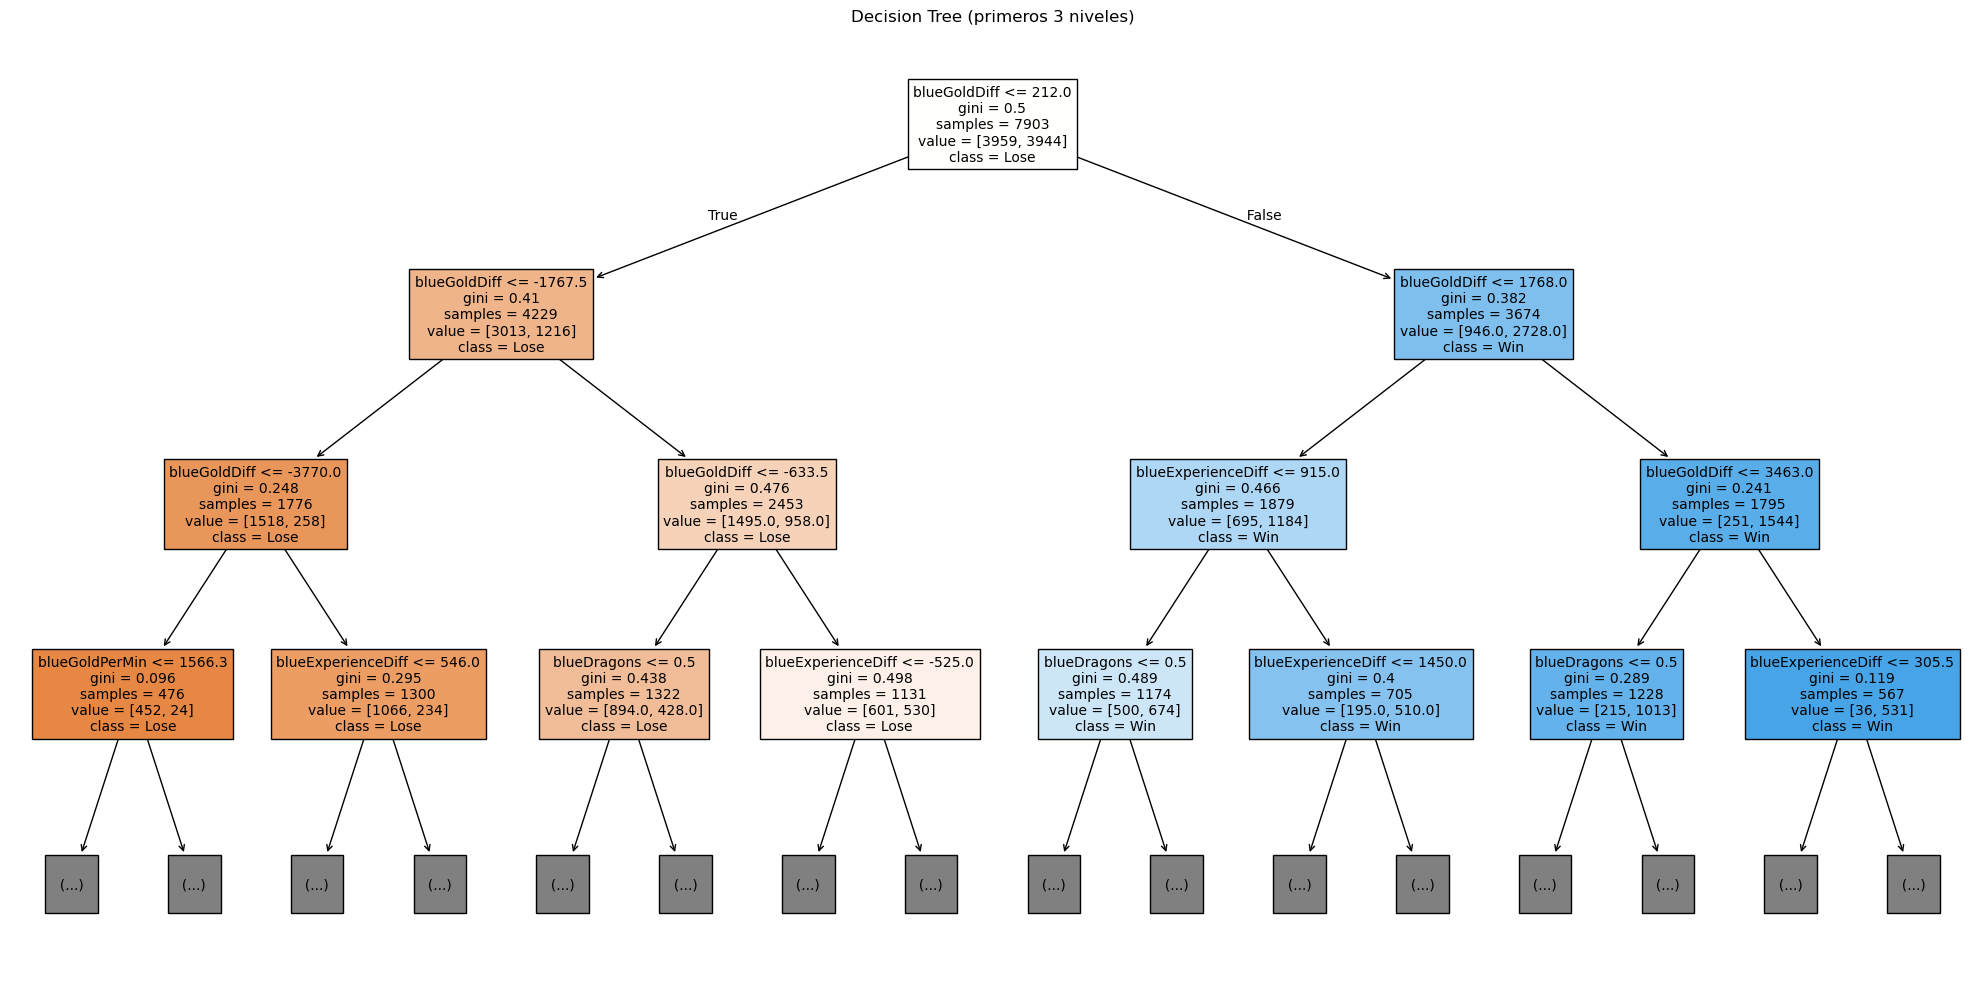

In [20]:
# Visualización del árbol (limitado a profundidad 3 para poder verlo)
plt.figure(figsize=(20, 10))
plot_tree(tree, 
          max_depth=3,
          feature_names=X.columns,
          class_names=['Lose', 'Win'],
          filled=True,
          fontsize=10)
plt.title('Decision Tree (primeros 3 niveles)')
plt.tight_layout()
plt.show()


Top 5 Features más importantes:
                         feature  importance
15                  blueGoldDiff    0.636151
16            blueExperienceDiff    0.068964
12           blueTotalExperience    0.059611
14  blueTotalJungleMinionsKilled    0.028485
13        blueTotalMinionsKilled    0.025744


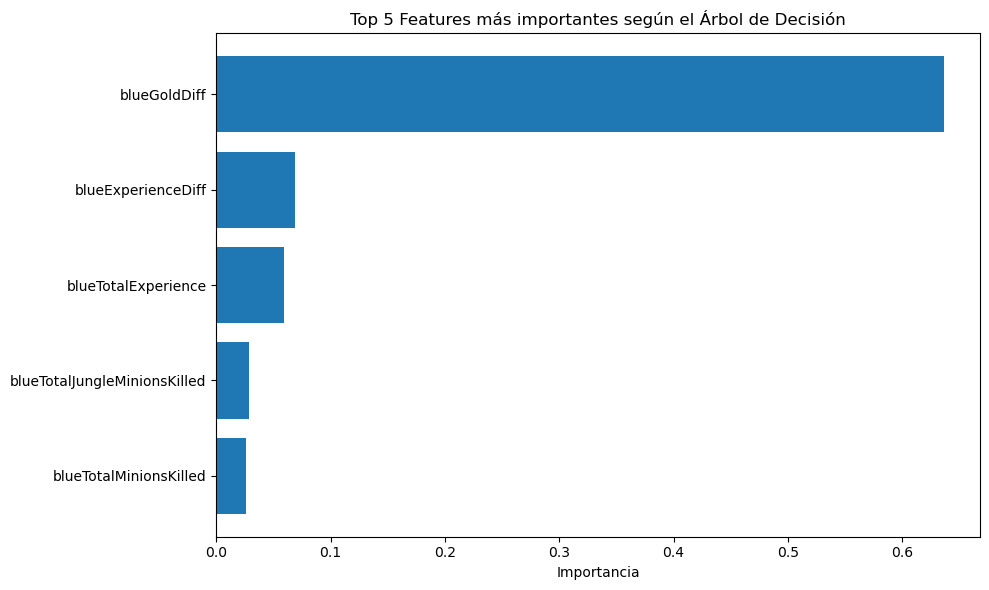

In [21]:
# Feature Importance - Top 5 variables más importantes
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)

top_5 = feature_importance.head(5)

print("\nTop 5 Features más importantes:")
print(top_5)

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(top_5['feature'], top_5['importance'])
plt.xlabel('Importancia')
plt.title('Top 5 Features más importantes según el Árbol de Decisión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Interpretación para jugadores de LoL:**

Las variables más importantes generalmente son:
- **blueGoldDiff**: Diferencia de oro - es crítico porque oro = items = poder
- **blueExperienceDiff**: Diferencia de experiencia - nivel más alto = stats más fuertes
- **blueKills**: Kills dan oro y ventaja de mapa
- **blueTotalGold**: Oro total del equipo
- **blueGoldPerMin**: Tasa de crecimiento de oro

Los dragones y heraldos también son importantes porque dan buffs permanentes al equipo.

### 4. Comparación Final


COMPARACIÓN FINAL DE MODELOS
       Modelo  Accuracy
   SVM Lineal  0.719636
      SVM RBF  0.718623
Decision Tree  0.689271


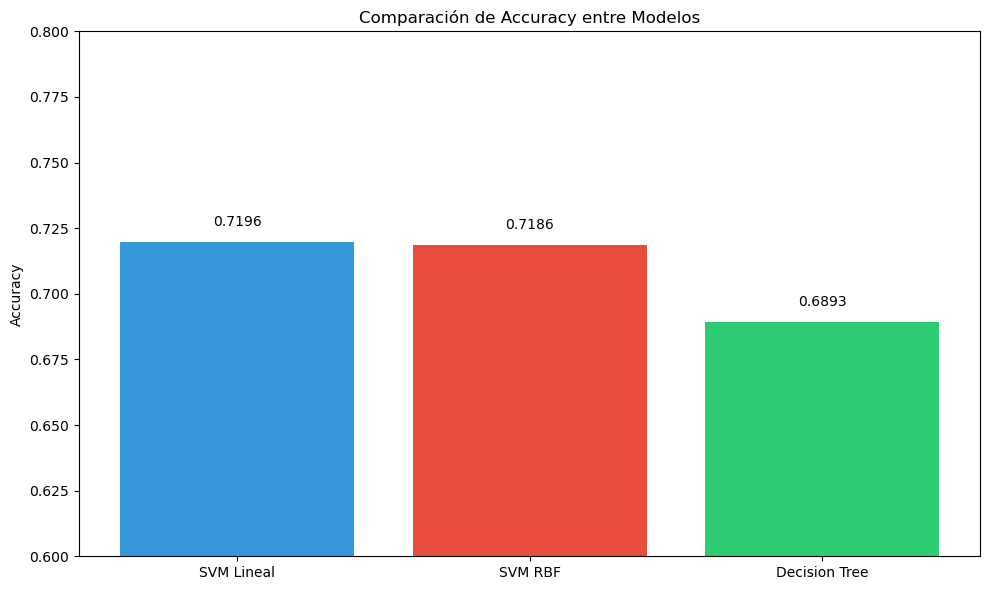

In [22]:
# Tabla comparativa
results = pd.DataFrame({
    'Modelo': ['SVM Lineal', 'SVM RBF', 'Decision Tree'],
    'Accuracy': [acc_linear, acc_rbf, acc_tree]
}).sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("COMPARACIÓN FINAL DE MODELOS")
print("="*60)
print(results.to_string(index=False))

# Visualización
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
plt.bar(results['Modelo'], results['Accuracy'], color=colors)
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.ylim([0.6, 0.8])
for i, v in enumerate(results['Accuracy']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Análisis y Conclusiones

In [23]:
# Determinar el mejor modelo
best_model = results.iloc[0]['Modelo']
best_acc = results.iloc[0]['Accuracy']

print("\n" + "="*80)
print("CONCLUSIONES")
print("="*80)

print(f"\n1. DESEMPEÑO NUMÉRICO:")
print(f"   → Mejor modelo: {best_model} con {best_acc:.4f} ({best_acc*100:.2f}%) accuracy")

print(f"\n2. INTERPRETABILIDAD PARA ANALISTAS DE E-SPORTS:")
print(f"   → Modelo recomendado: Decision Tree")
print(f"   ")
print(f"   Razones:")
print(f"   • Los árboles de decisión son INTERPRETABLES: podemos ver exactamente")
print(f"     qué decisiones toma el modelo (ej: 'Si goldDiff > 1500, entonces ganar')")
print(f"   ")
print(f"   • Un analista puede EXPLICAR a los jugadores por qué ganaron/perdieron:")
print(f"     'Perdieron porque su diferencia de oro era -2000 al minuto 10'")
print(f"   ")
print(f"   • SVM es una 'caja negra': solo nos dice la predicción pero no")
print(f"     podemos entender QUÉ factores fueron decisivos")
print(f"   ")
print(f"   • Feature Importance del árbol nos dice QUÉ trabajar en práctica")
print(f"   ")
print(f"   • Los árboles dan REGLAS ACCIONABLES para coaches y jugadores")

print(f"\n3. SEPARABILIDAD LINEAL:")
if acc_rbf > acc_linear:
    print(f"   → Los datos NO son linealmente separables")
    print(f"   → Las victorias en LoL dependen de interacciones COMPLEJAS entre variables")
    print(f"   → No hay una relación lineal simple como 'más oro = ganar'")
    print(f"   → Las combinaciones de factores importan (oro + kills + objetivos)")
else:
    print(f"   → Los datos son aproximadamente linealmente separables")
    print(f"   → Una combinación lineal de factores puede predecir bien")

print(f"\n4. TRADE-OFF:")
print(f"   • Si SOLO importa la precisión → Usar el mejor modelo ({best_model})")
print(f"   • Si importa EXPLICAR las decisiones → Usar Decision Tree")
print(f"   • Para analistas de e-sports → SIEMPRE preferir interpretabilidad")
print(f"     porque necesitan dar feedback específico a los jugadores")

print("\n" + "="*80)


CONCLUSIONES

1. DESEMPEÑO NUMÉRICO:
   → Mejor modelo: SVM Lineal con 0.7196 (71.96%) accuracy

2. INTERPRETABILIDAD PARA ANALISTAS DE E-SPORTS:
   → Modelo recomendado: Decision Tree
   
   Razones:
   • Los árboles de decisión son INTERPRETABLES: podemos ver exactamente
     qué decisiones toma el modelo (ej: 'Si goldDiff > 1500, entonces ganar')
   
   • Un analista puede EXPLICAR a los jugadores por qué ganaron/perdieron:
     'Perdieron porque su diferencia de oro era -2000 al minuto 10'
   
   • SVM es una 'caja negra': solo nos dice la predicción pero no
     podemos entender QUÉ factores fueron decisivos
   
   • Feature Importance del árbol nos dice QUÉ trabajar en práctica
   
   • Los árboles dan REGLAS ACCIONABLES para coaches y jugadores

3. SEPARABILIDAD LINEAL:
   → Los datos son aproximadamente linealmente separables
   → Una combinación lineal de factores puede predecir bien

4. TRADE-OFF:
   • Si SOLO importa la precisión → Usar el mejor modelo (SVM Lineal)
   • Si 